# Logistic Regression

## Indice
1. Preparação do Dataset
2. Pré-processamento de Imagens
3. Separação em Treino/Teste
4. Treinamento dos Modelos
5. Avaliação de Desempenho
6. Visualização dos Resultados (Opcional)
7. Melhorias Futuras (fora do escopo básico)

# 0 Importação das Bibliotecas

In [27]:
import numpy as np
import pandas as pd
import os 
import random
import zipfile
import glob
import cv2
import time
import joblib
import json

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [3]:
from tqdm import tqdm   # <-- esta linha corrige o erro
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    log_loss
)
from sklearn.preprocessing import LabelEncoder

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers

In [5]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Carregar o dataset

In [6]:
path = '../data/Plastic_Classification.zip'

In [7]:
# descompactar o .zip
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall('./datasets')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='../data/Plastic_Classification.zip' mode='r'>>

In [8]:
# carregar as imagens
dataset = r"./datasets/Plastic_Classification/"

In [9]:
# Define os caminhos para cada conjunto
pasta_test = os.path.join(dataset, "test")
pasta_train = os.path.join(dataset, "train")
pasta_validation = os.path.join(dataset, "validation")

In [10]:
# Função para listar classes e contar imagens
def contar_imagens_por_classe(pasta_base):
    print(f"\n📁 Pasta: {pasta_base}")
    total_imagens = 0

    # Lista apenas subpastas válidas (classes)
    classes = [
        c for c in os.listdir(pasta_base) if os.path.isdir(os.path.join(pasta_base, c))
    ]

    for classe in sorted(classes):
        caminho_classe = os.path.join(pasta_base, classe)

        # Lista arquivos de imagem válidos
        imagens = [
            f
            for f in os.listdir(caminho_classe)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        qtd = len(imagens)
        total_imagens += qtd

        print(f"🧪 Classe '{classe}': {qtd} imagens")

    print(f"📊 Total de imagens em '{os.path.basename(pasta_base)}': {total_imagens}")


# Executa para cada pasta
contar_imagens_por_classe(pasta_train)
contar_imagens_por_classe(pasta_test)
contar_imagens_por_classe(pasta_validation)


📁 Pasta: ./datasets/Plastic_Classification/train
🧪 Classe 'HDPE': 209 imagens
🧪 Classe 'LDPA': 208 imagens
🧪 Classe 'Other': 202 imagens
🧪 Classe 'PET': 205 imagens
🧪 Classe 'PP': 209 imagens
🧪 Classe 'PS': 207 imagens
🧪 Classe 'PVC': 201 imagens
📊 Total de imagens em 'train': 1441

📁 Pasta: ./datasets/Plastic_Classification/test
🧪 Classe 'HDPE': 30 imagens
🧪 Classe 'LDPA': 30 imagens
🧪 Classe 'Other': 30 imagens
🧪 Classe 'PET': 29 imagens
🧪 Classe 'PP': 30 imagens
🧪 Classe 'PS': 30 imagens
🧪 Classe 'PVC': 30 imagens
📊 Total de imagens em 'test': 209

📁 Pasta: ./datasets/Plastic_Classification/validation
🧪 Classe 'HDPE': 58 imagens
🧪 Classe 'LDPA': 60 imagens
🧪 Classe 'Other': 60 imagens
🧪 Classe 'PET': 59 imagens
🧪 Classe 'PP': 60 imagens
🧪 Classe 'PS': 59 imagens
🧪 Classe 'PVC': 60 imagens
📊 Total de imagens em 'validation': 416


## 2 Pré-processamento

**Leitura das imagens:**

- Convertidas para tons de cinza

- Redimensionadas para 64×64

- Transformadas em vetores (flatten)

**Normalização dos pixels:**

- Os valores foram convertidos para escala [0, 1]

**Codificação dos rótulos (labels):**

- Usamos LabelEncoder() para transformar strings em números

## 2.1 configuração das imagens

In [11]:
image_width = 64
image_height = 64
image_size = (image_width, image_height)
max_pixel_value = 255.0

In [12]:
# Definir caminhos
dataset = "./datasets/Plastic_Classification"
pasta_train = os.path.join(dataset, "train")
pasta_val = os.path.join(dataset, "validation")
pasta_test = os.path.join(dataset, "test")



In [13]:
# -------------------------------
# FUNÇÃO PARA CARREGAR IMAGENS
# -------------------------------
def carregar_imagens(pasta):
    X, y = [], []
    classes = sorted(os.listdir(pasta))
    for classe in classes:
        caminho_classe = os.path.join(pasta, classe)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in tqdm(glob.glob(os.path.join(caminho_classe, "*.jpg")), desc=f"Carregando {classe}"):
            img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            X.append(img.flatten())  # (4096,)
            y.append(classe)
    return np.array(X) / max_pixel_value, np.array(y)

In [14]:

# -------------------------------
# CARREGAR E PRÉ-PROCESSAR DADOS
# -------------------------------
X_train, y_train = carregar_imagens(pasta_train)
X_val, y_val = carregar_imagens(pasta_val)
X_test, y_test = carregar_imagens(pasta_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)
class_names = le.classes_

Carregando PVC: 100%|██████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.84it/s]


In [17]:
# -------------------------------
# TREINAMENTO DO MODELO
# -------------------------------
model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='saga',
    max_iter=3000,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

from sklearn.decomposition import PCA

# Reduz para 300 componentes principais
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# depois use X_train_pca e X_test_pca no modelo


start_train = time.time()
model.fit(X_train_pca, y_train_enc)
train_time = time.time() - start_train


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 1231 epochs took 58 seconds


| Informação               | Significado                                               |
| ------------------------ | --------------------------------------------------------- |
| `convergence after 1231` | O modelo encontrou uma solução ótima em 1231 iterações    |
| `took 58 seconds`        | Tempo total de treinamento foi de apenas 58 segundos      |
| `ThreadingBackend`       | Usou 4 núcleos da CPU em paralelo (graças ao `n_jobs=-1`) |


In [18]:
# avaliação

✅ Acurácia

🎯 F1-score ponderado

📉 Log Loss

⚡ Tempo de inferência

📋 Classification Report

📊 Matriz de Confusão


🧠 Tempo de treino: 57.57s
⚡ Tempo médio de inferência por imagem: 0.01 ms
✅ Acurácia: 0.2967
🎯 F1-score ponderado: 0.2862
📉 Log Loss: 2.7756

📋 Relatório por classe:

              precision    recall  f1-score   support

        HDPE       0.17      0.20      0.18        30
        LDPA       0.33      0.33      0.33        30
       Other       0.18      0.13      0.15        30
         PET       0.21      0.14      0.17        29
          PP       0.50      0.63      0.56        30
          PS       0.33      0.40      0.36        30
         PVC       0.25      0.23      0.24        30

    accuracy                           0.30       209
   macro avg       0.28      0.30      0.29       209
weighted avg       0.28      0.30      0.29       209



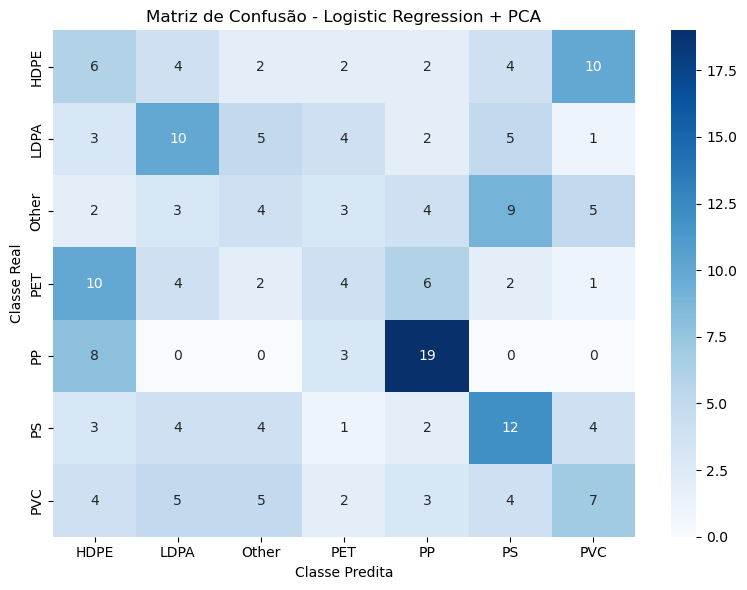

In [19]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Avaliação
start_pred = time.time()
y_pred = model.predict(X_test_pca)
inference_time = (time.time() - start_pred) / len(X_test_pca)

# Probabilidades para log loss
y_proba = model.predict_proba(X_test_pca)

# Métricas
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average='weighted')
loss = log_loss(y_test_enc, y_proba)

# Resultados
print(f"\n🧠 Tempo de treino: {train_time:.2f}s")
print(f"⚡ Tempo médio de inferência por imagem: {inference_time*1000:.2f} ms")
print(f"✅ Acurácia: {acc:.4f}")
print(f"🎯 F1-score ponderado: {f1:.4f}")
print(f"📉 Log Loss: {loss:.4f}")
print("\n📋 Relatório por classe:\n")
print(classification_report(y_test_enc, y_pred, target_names=class_names))

# Matriz de confusão
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão - Logistic Regression + PCA")
plt.xlabel("Classe Predita")
plt.ylabel("Classe Real")
plt.tight_layout()
plt.show()


In [20]:
# previsão com o modelo (e rótulos decodificados)

In [21]:
# 🔮 Previsões com o modelo treinado
y_pred = model.predict(X_test_pca)

# 🔁 Converter os rótulos numéricos para nomes de classes
y_pred_labels = le.inverse_transform(y_pred)

# 📋 Exibir primeiras 10 previsões com suas classes
for i in range(10):
    print(f"Imagem {i+1}: Classe predita → {y_pred_labels[i]}")


Imagem 1: Classe predita → PVC
Imagem 2: Classe predita → PVC
Imagem 3: Classe predita → PVC
Imagem 4: Classe predita → Other
Imagem 5: Classe predita → HDPE
Imagem 6: Classe predita → HDPE
Imagem 7: Classe predita → PS
Imagem 8: Classe predita → PS
Imagem 9: Classe predita → PVC
Imagem 10: Classe predita → LDPA


In [22]:
# Rótulos reais decodificados
y_true_labels = le.inverse_transform(y_test_enc)

# Comparar lado a lado
for i in range(10):
    print(f"Imagem {i+1}: Real = {y_true_labels[i]} | Predito = {y_pred_labels[i]}")

Imagem 1: Real = HDPE | Predito = PVC
Imagem 2: Real = HDPE | Predito = PVC
Imagem 3: Real = HDPE | Predito = PVC
Imagem 4: Real = HDPE | Predito = Other
Imagem 5: Real = HDPE | Predito = HDPE
Imagem 6: Real = HDPE | Predito = HDPE
Imagem 7: Real = HDPE | Predito = PS
Imagem 8: Real = HDPE | Predito = PS
Imagem 9: Real = HDPE | Predito = PVC
Imagem 10: Real = HDPE | Predito = LDPA


C:\Users\graci.DESKTOP-I7T8UK6\AppData\Local\Temp\ipykernel_15568\251464451.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


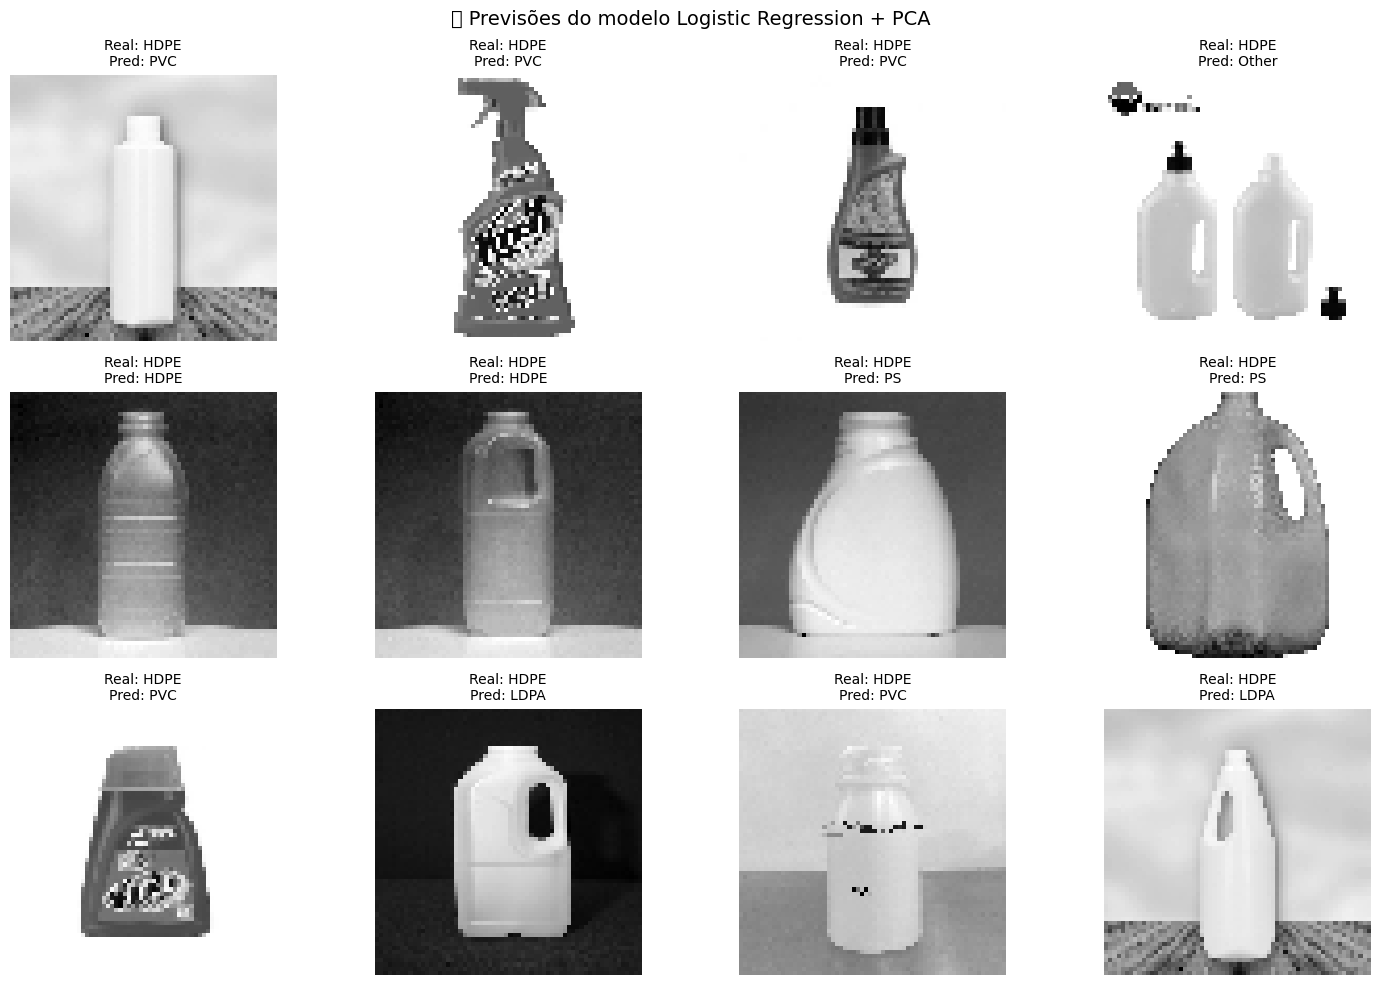

In [23]:
import matplotlib.pyplot as plt

# Número de imagens para mostrar
num_images = 12

# Recriar as imagens originais a partir do X_test
X_test_imgs = X_test.reshape((-1, 64, 64)) * 255.0  # Reverter normalização para exibir

# Decodificar os rótulos
y_true_labels = le.inverse_transform(y_test_enc)
y_pred_labels = le.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(15, 10))
for i in range(num_images):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Real: {y_true_labels[i]}\nPred: {y_pred_labels[i]}", fontsize=10)
plt.suptitle("🔍 Previsões do modelo Logistic Regression + PCA", fontsize=14)
plt.tight_layout()
plt.show()


## Salvar o modelo e o PCA

1. O modelo treinado (Regressão Logística com PCA)
2. O modelo PCA usado para transformar os dados
3. As métricas de avaliação (JSON ou CSV)

In [26]:
# Criar pasta se não existir
os.makedirs("models", exist_ok=True)

# Salvar o modelo treinado
joblib.dump(model, "models/01_logistic_regression/logistic_regression_model.joblib")

# Salvar o PCA
joblib.dump(pca, "models/pca_transformer_logistic_regression.joblib")

# Salvar o codificador de rótulos
joblib.dump(le, "models/label_encoder_logistic_regression.joblib")


['models/label_encoder_logistic_regression.joblib']

In [29]:


# Dicionário com métricas
metrics = {
    "model": "Logistic Regression + PCA",
    "accuracy": acc,
    "f1_score_weighted": f1,
    "log_loss": loss,
    "train_time_sec": train_time,
    "inference_time_per_image_ms": inference_time * 1000
}

# Salvar em arquivo JSON
with open("models/logistic_regression_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)


# Carregar modelo e pca
'''
model = joblib.load("models/logistic_regression_model.joblib")
pca = joblib.load("models/pca_transformer.joblib")
le = joblib.load("models/label_encoder.joblib")

# Aplicar o PCA novamente ao novo conjunto de dados antes da predição
X_new_pca = pca.transform(X_new)
preds = model.predict(X_new_pca)
labels = le.inverse_transform(preds)
